# HARey constellation cards

Hans Augusto Reyersbach (pen name HARey) was an illustrator who wrote the book _Find the constellations_ to teach children about stargazing. In the book he redrawn the constellations diagrams to be more similar to the objects they are named after, instead of the complicated and indistinguishable. 

This project is my personal homage to HArey's work, and it borrows his idea of making learning the constellations a challenge by creating a Memory-like game to recognize the constellations without the lines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import pandas as pd

## The project base
This project borrows a lot from Stellarium, an open source planetary software. In the Sky Culture section users can see different constellations shapes created by different cultures, and among them there are the HARey drawings. The _index.json_ file provides the constellation lines data and asterisms and the Hipparcos catalogues provides the stars positions to draw the constellations.

In [2]:
from HARey_constellation_cards.astro_projection import Observer,stereographic_projection, is_visible
from HARey_constellation_cards.loader import load_constellations, load_stars

The __constellations__ dictionary contains each constellations lines and stars. The key is an abbreviation of the constellation name (e.g., Ori for Orion). Constellations with keys like __.Orib__ are a subgroup of stars that are assigned a name by HARey (e.g. .Orib is Orion's belt). The __main_ids__ list contains the ids of the constellations. 

In [3]:
# Load the constellations  
constellations, main_ids, asterisms, helpers, named_stars = load_constellations('index.json')
# Load the stars positions and the constellations they belong to
stars = load_stars('hip_main.dat')

The stars are projected using a __stereographic__ projection, which is a projection from a spherical surface to a plane which conserves the angles at which lines meet, locally preserving the shapes (further from the center, the stretching distorts the overall diagram). The center of the projection is the brightest star of each constellation.

In [4]:
stars = stars[stars['magnitude'] < 5]
local_stars = stars.loc[constellations['UMa']['stars']]
brightest_star = local_stars.iloc[np.argmin(local_stars['magnitude'])]
projection = stereographic_projection(brightest_star['ra'], brightest_star['dec'])

stars_x, stars_y = projection(stars['ra'], stars['dec'])

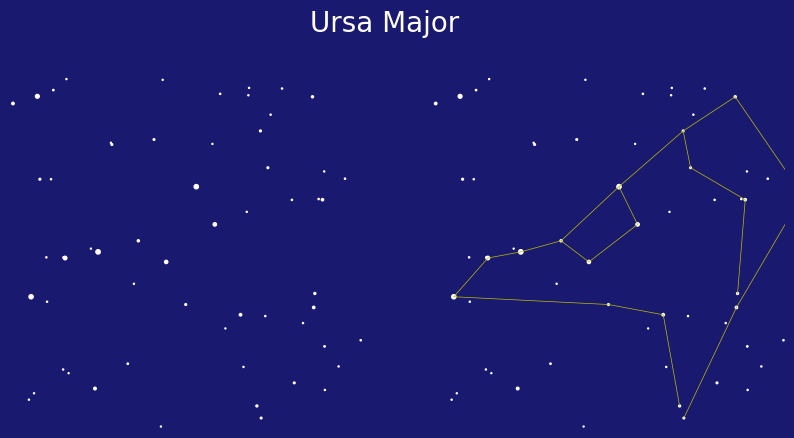

In [5]:
fig, (ax1, ax2) = plt.subplots(facecolor='midnightblue', ncols = 2, figsize=(10,5))
fig.suptitle('Ursa Major', color='w', fontsize = 20)
ax1.set_aspect('equal')
ax1.set_axis_off()
ax1.set_xlim(-0.1,0.3)
ax1.set_ylim(-0.2,0.2)

# The stars size depends on their magnitude
ax1.scatter(stars_x, stars_y, s=50*10**(stars['magnitude']/-2.5), color='w')

ax2.set_aspect('equal')
ax2.set_axis_off()
ax2.set_xlim(-0.1,0.3)
ax2.set_ylim(-0.2,0.2)

# Plot the lines of the constellations Ursa Major
for line in constellations['UMa']['lines']:
    ax2.plot(stars_x[line], stars_y[line], color='y', linewidth=0.5)
    
ax2.scatter(stars_x, stars_y, s=50*10**(stars['magnitude']/-2.5), color='w')
plt.show()

# The HARey module
The process of creating the constellations plots is automated by the HARey module, which creates plots that fit inside a playing card template.

To make cards that can be used by everyone, I added the __names.csv__ file, which contains the keys to identify the objects inside the HARey module and the translated names. The default language is COMMON, which is the standard IAU denomination of objects; ENGLISH uses the names that HARey wrote in his book. 

The names also include newlines to wrap around long ones (this works in the Matplotlib plots but not in InkScape, see the SIS_SCRIPT section).

In [6]:
from HARey_constellation_cards.harey_main import HAReyMain

In [7]:
# Read the constellations file, the HIP catalogue and the object names
harey = HAReyMain(language='ITALIANO', star_colors='helland')

# Set two custom fonts for the plots and the cards names
harey.set_fonts('fonts/CaveatBrush-Regular.ttf', 'fonts/TheWalkyr.ttf')

# Using a card template different than the default one
#harey.set_card_template('tarot-square', cardback_file= 'cardbacks/tarot_square.png')

Loading constellations diagrams....     Done!
Loading star coordinates....     Done!
Computing stars colors, sizes and markers...     Done!
Loading custom markers....       Done!
Loading the object names....       Done!


Using the tarot-round format, 2.75x4.75 in, using the template at cardbacks/tarot_round.png
Using Caveat Brush for plot labels
Using The Walkyr for card names


## Star sizes and colors
In his books, HARey drew different markers for different magnitudes, making it easier to see the magnitude of each star. This is the default option of the __HAReyMain__ module, but it can be disabled with __.set_HARey_markers_off()__ to return to a more standard look.

The size of a star depends on its brightness, which is computed from its magnitude $M$ as $B=B_0\cdot 10 ^{-0.4M}$. The brightness is translated in the scatter points sizes, which is proportional to the area. Having also different markers to discriminate them, I decided to use a less steep scale function, by using $s=s_0\cdot 10^{-0.2M}$ up to $M=3.5$, then switch to $s=s_0\cdot 10^{-0.4}$ for stars of 4th or higher magnitudine, which are all dots.

 In his books, HARey used a six-pointed stars for 3rd magnitude, a 5-pointed one for 4th and a dot for 5th or more, but as I'm using all the stars and not only the ones in a constellation figure, I had a lot of stars which are represented as dots as they are not part of a constellation yet are brighter than 5th magnitude. Most are of the 4th one, so using one less symbol mostly fixed it. 

The default limiting magnitude is 7, which is a compromise between a really fancy plot, which fully utilizes the Hipparcos data, and a cleaner one which helps seeing the constellation.

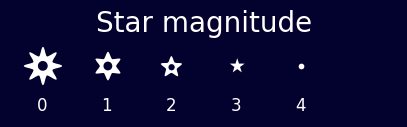

In [8]:
fig = harey.plot_legend()
plt.show()

For a bit of flare, each star has its own color, defined by the B-V color index. This value is converted in a RGB color using a colormap present in the Stellarium software.

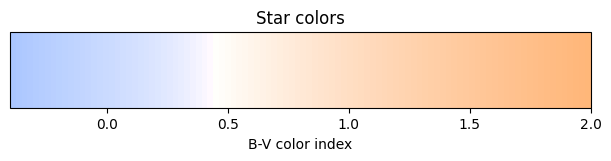

In [9]:
fig = harey.plot_star_cmap()
plt.show()

## Plotting options
The following functions share most of these FLAGS to enable or disable plotting options:
- __CON_LINES__ : Plot the constellation lines
- __ASTERISMS__ : Plot the asterisms lines. Asterisms are patterns of stars that are easy to recognize but not a constellation (e.g. the Big Dipper)
- __HELPERS__ : Plot the helper lines. These are imaginary lines that connect stars to each other and make it easier to find features in the sky (in the sky the lines are pretty much straight, in the plots this doesn't happen due to deformations and the fact that are described as a polyline)
- __STAR_COLORS__ : Use the real star colors in the plots. Otherwise, all the stars will be white
- __CON_NAMES__ : Show the constellation names
- __CON_PARTS__ : Show the constellation parts (e.g. feet, head, body, ecc.) from the HARey diagrams
- __STAR_NAMES__ : Plot the brightest stars names
- __SHOW__ : Show the image (default True)
- __SAVE__ : Save the figure
- __SIS_SCRIPT__ : Creates a Simple InkScape Script for the labels. See the next section.



## The SIS_SCRIPT option
Plotting the labels proved a more difficult task than expected as there is no simple way to put the labels without overlapping other labels or objects. I've tried the python libraries _adjustText_ and _textalloc_ that fix this issue by moving each label away and then try to dynamically simulate their movement towards their initial position while avoiding everything else, but found that it took too long to simulate the movements and the result was not satisfactory (also, there is no way to rotate the labels).

For this reason I decided to manually fix the labels before printing the cards. To simplify this tedious task, I used InkScape with the extension Simple Inkscape Scripting, which enables python-like scripts to perform repetitive tasks in InkScape, to automatically plot all the labels as text fields that can be manipulated. 

To do this, enable the SIS_SCRIPT flag and a new _image_name.py_ file will be created inside the folder inkscape_scripts containing the labels informations. Now open the image (saved without labels) in Inkscape and resize the canvas to the image (file-> Document Properties -> Resize to content). Then go to Extensions -> Render -> Simple InkScape Scripting and select the _image_name.py_ file and launch it with Apply. All the labels will appear in the image in the right position and color (but no newlines, sorry), and fixing them will hopefully require only some resizing and a small translation.

## Constellations cards
The constelllations are projected around the brightest star using a stereographic projection that preserves the shapes.

 When the __BEST_AR__ flag is enabled, the stars are rotated to minimize the aspect ratio (x-spread over y-spread) and fill as much as possible the card space. Otherwise, the card is plotted North up. Stars that are not part of the constellations are plotted with a little transparency to make it easier to see the constellation.

Also, __CON_NAMES__, __ASTERISMS__ and __HELPERS__ are not present in a single card because they mostly concern many constellations at once.

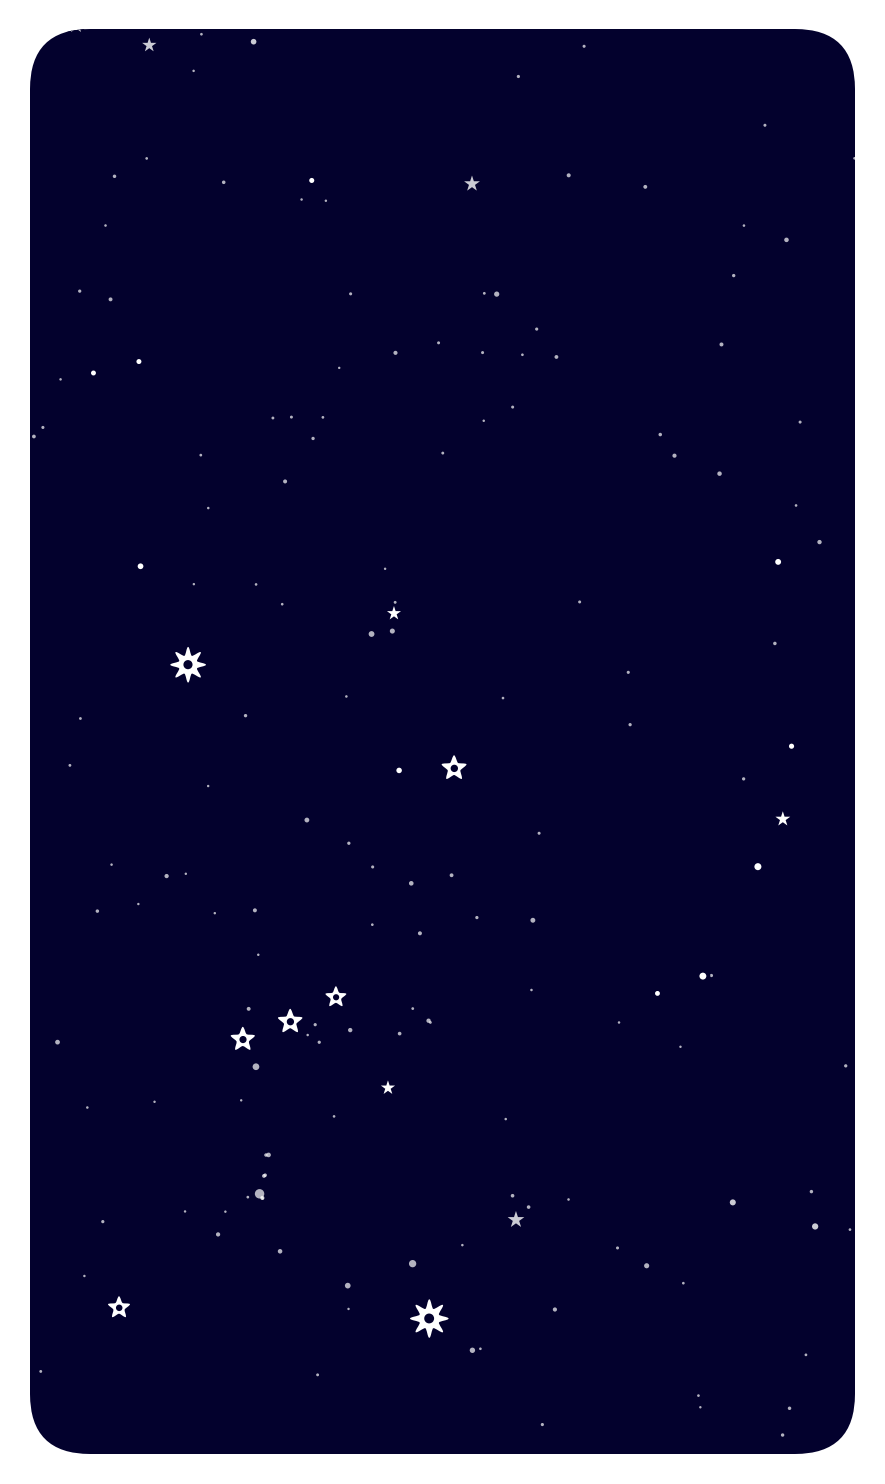

In [10]:
harey.set_limiting_magnitude(6)
harey.plot_card('Ori', CON_LINES=False, BEST_AR=True)


And here the same constellation, but with colored stars

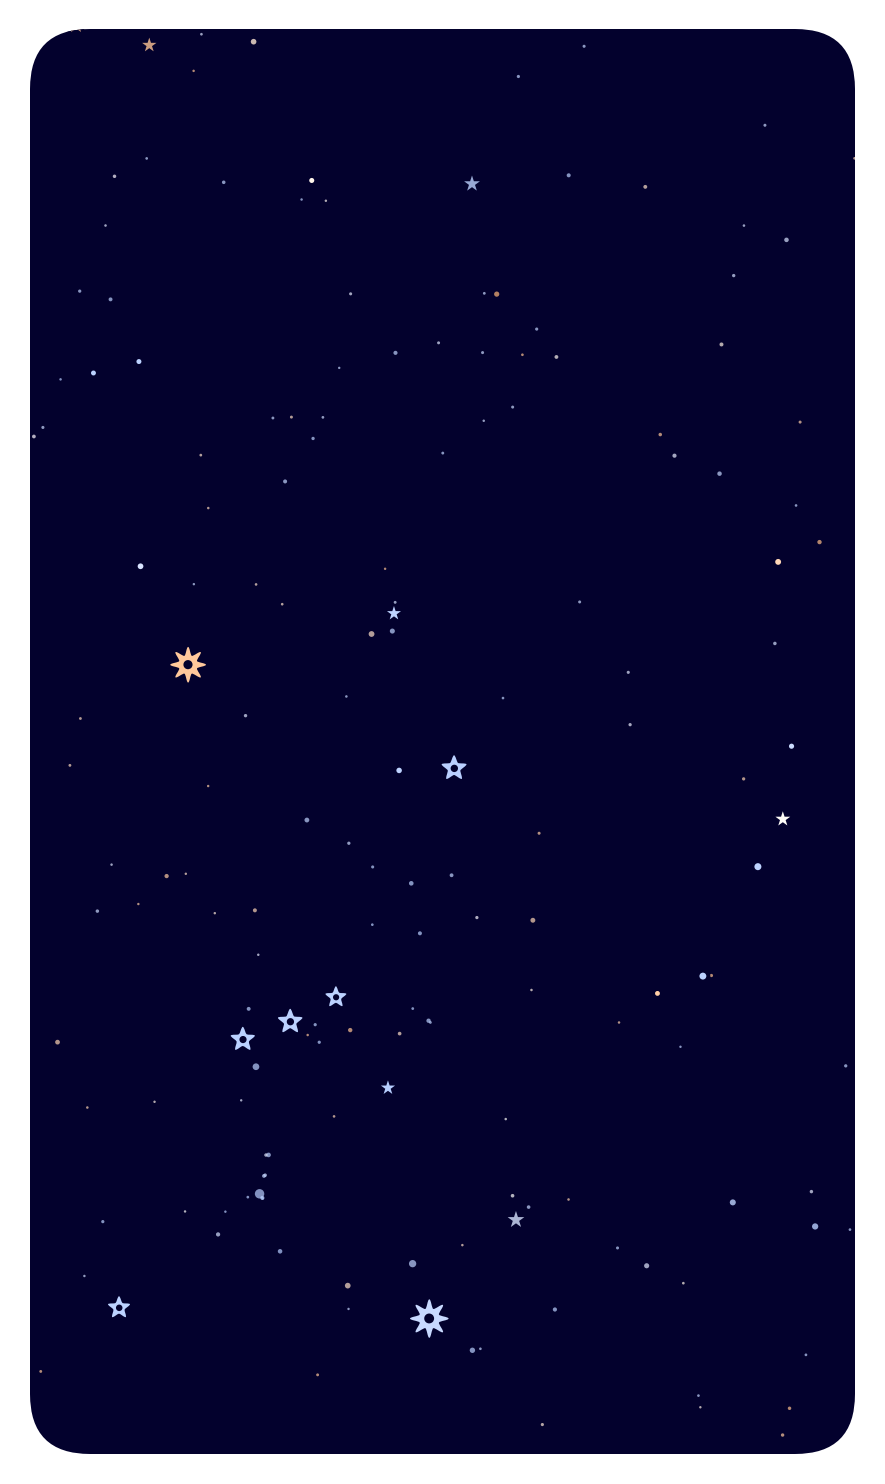

In [11]:
harey.plot_card('Ori', CON_LINES=False, BEST_AR=True, STAR_COLORS=True)

And finally, with a clean modern look. Just for fun, let's cranck the limiting magnitudine up to 11 (the maximum in the Hipparcos catalogue is around 13)

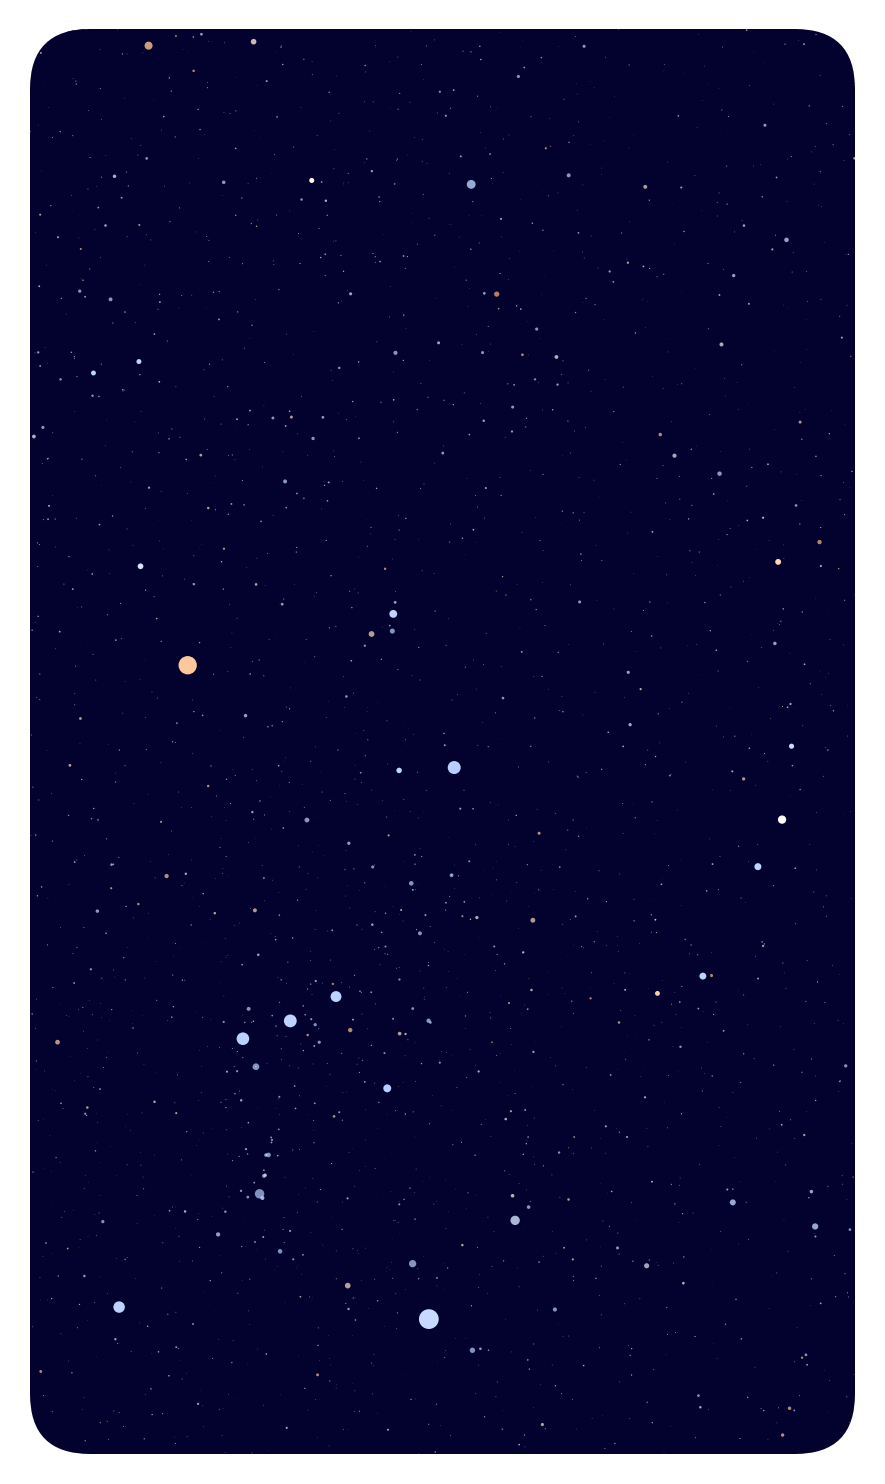

In [12]:
harey.set_limiting_magnitude(11)
harey.set_HARey_markers_off()
harey.plot_card('Ori', CON_LINES=False, BEST_AR=True, STAR_COLORS=True)
harey.set_HARey_markers_on()

Let's plot in the constellation lines and the labels. The labels position is not very good, so I recommend to manually adjust the lables in InkScape before printing a card set.

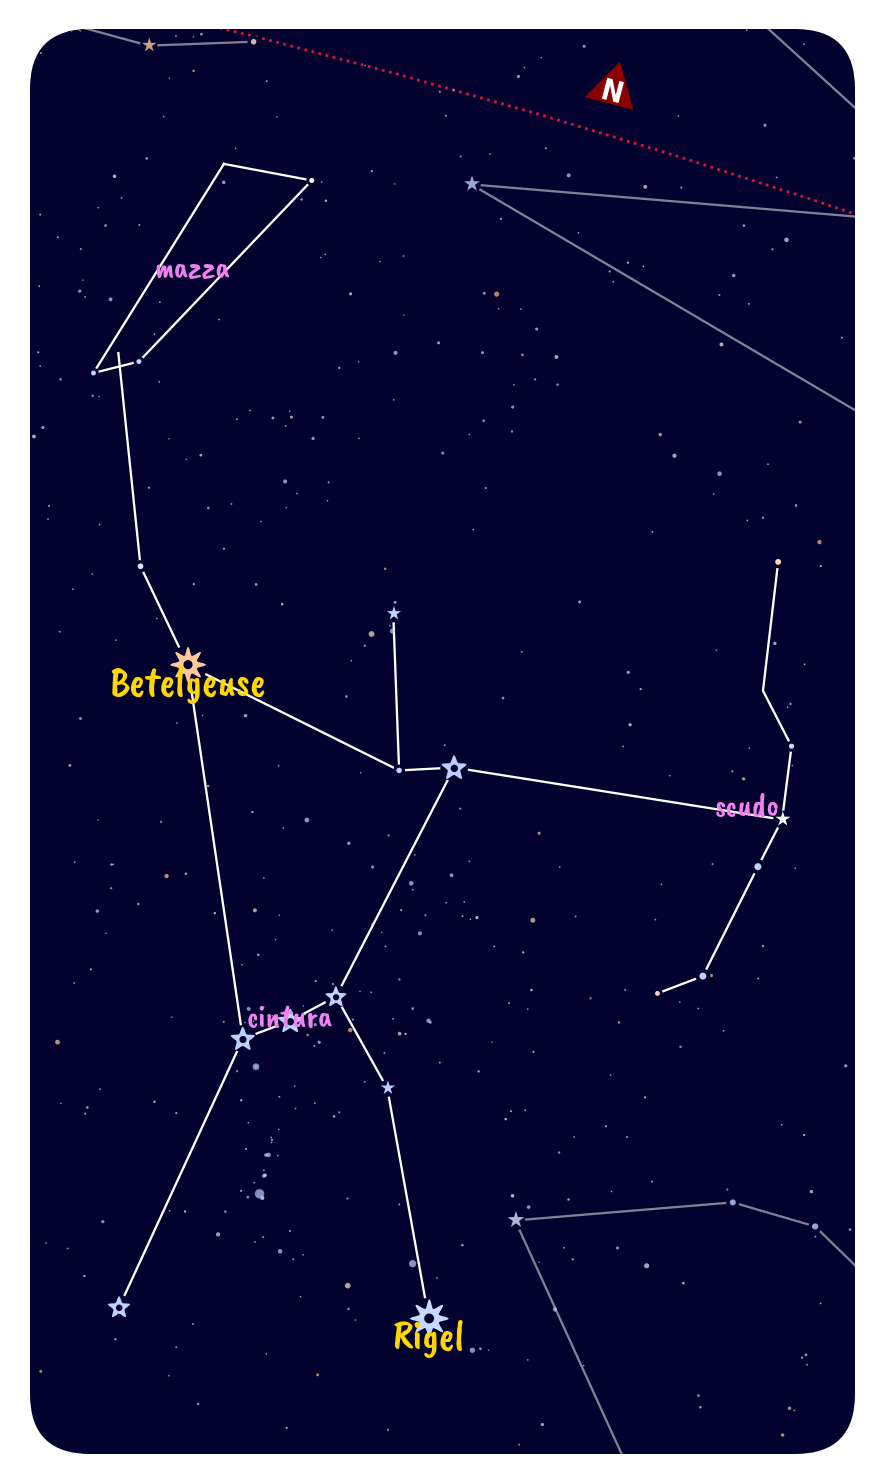

In [13]:
harey.set_limiting_magnitude(7)
harey.plot_card('Ori', CON_LINES=True, BEST_AR=True, CON_PARTS = True, STAR_NAMES=True, STAR_COLORS=True)

__plot_cardback__ creates the cardback for the constellations, colorizing the bw image of the cardback and adding the name of the constellation.

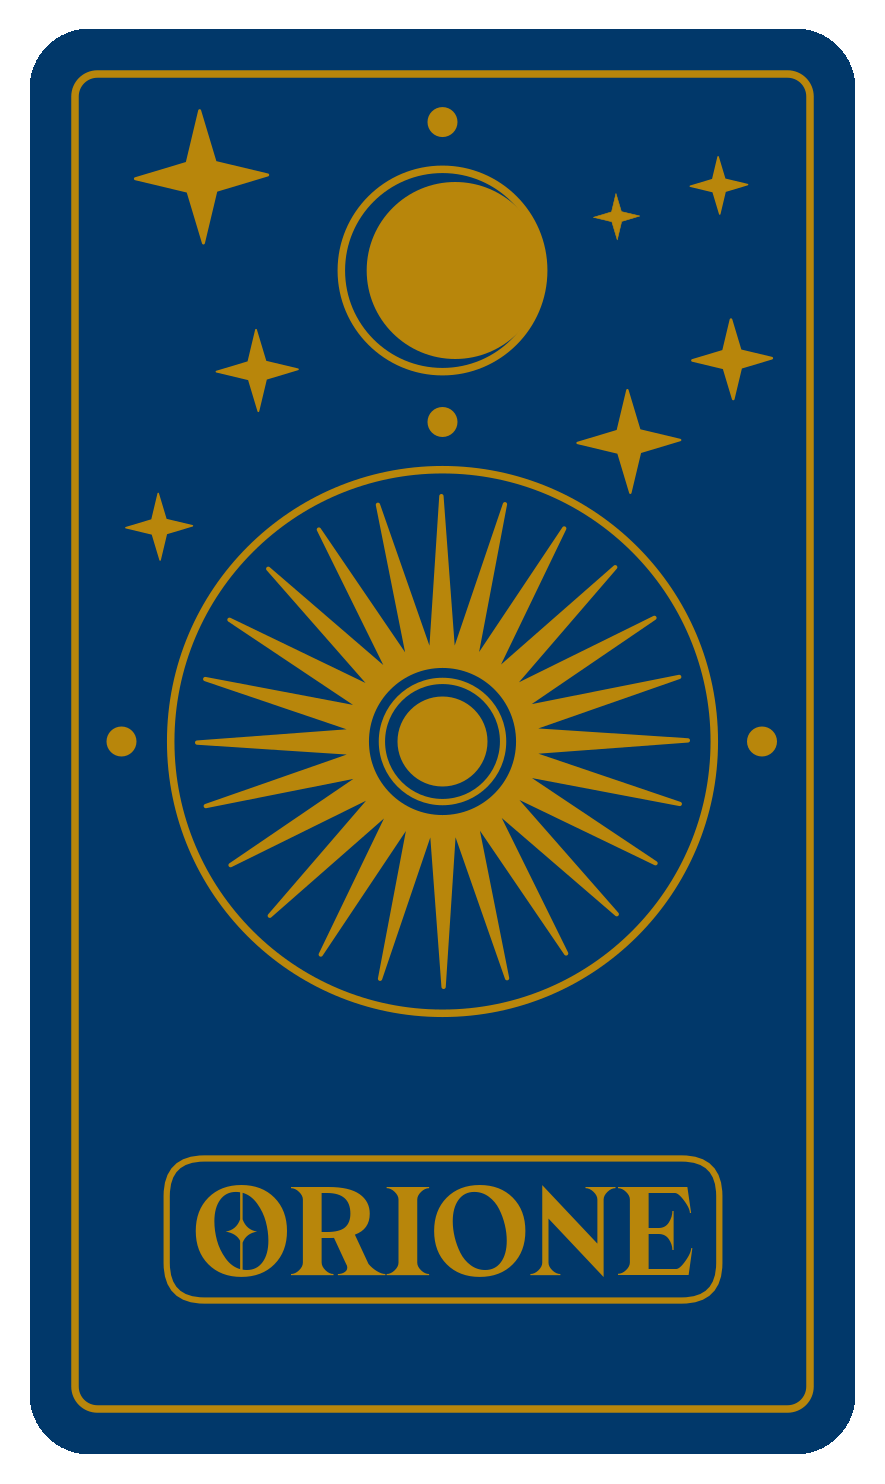

In [14]:
harey.plot_cardback('Ori')

## Printing the cards
The actual print is done by first creating all the sets inside a folder, the using the print-and-play method to arrange all the cards inside a pdf. __print_card_set__ creates a card set for one constellation (an image of the constellation without lines, one with lines, and two different cardbacks)

In [15]:
plot_constellations = ['Ori', 'Gem', 'Tau', 'UMa']

for id in plot_constellations:
	print(f'Creating card set for {harey.names[id].replace('\n', ' ')} ({id})')
	harey.print_card_set(id, save_folder='Card_output', STAR_COLORS=True, SIS_SCRIPT=True, bleed=0.2)
	


Creating card set for Orione (Ori)
Creating card set for Gemelli (Gem)
Creating card set for Toro (Tau)
Creating card set for Orsa Maggiore (UMa)


__print_and_play__ arranges the cards inside the folder in a pdf document ready to print. The print is inteded to be 2-sided, and to avoid small misalignement between the fronts and the backs of the cards, the formers have been saved with a bleed of 0.2 inches, i.e. an extra area to completely cover the card backs, where the cutting should take place. 

In [16]:
harey.print_and_play(folder = 'Card_output', filename='Cards.pdf')


16 cards have been printed in the file Cards.pdf



## Plotting a star map for a given latitude and time
The __plot_sky_view__ method creates an alt-az view of the sky at a given time and location, with the same plotting options as before. 

In the sky views and sky maps, changes in the font and the overall size of the plot may change dramatically the stars and labels appearance. It may be necessary to use the __star_size__ and __font_sizes__ options a lot to achieve a good result.

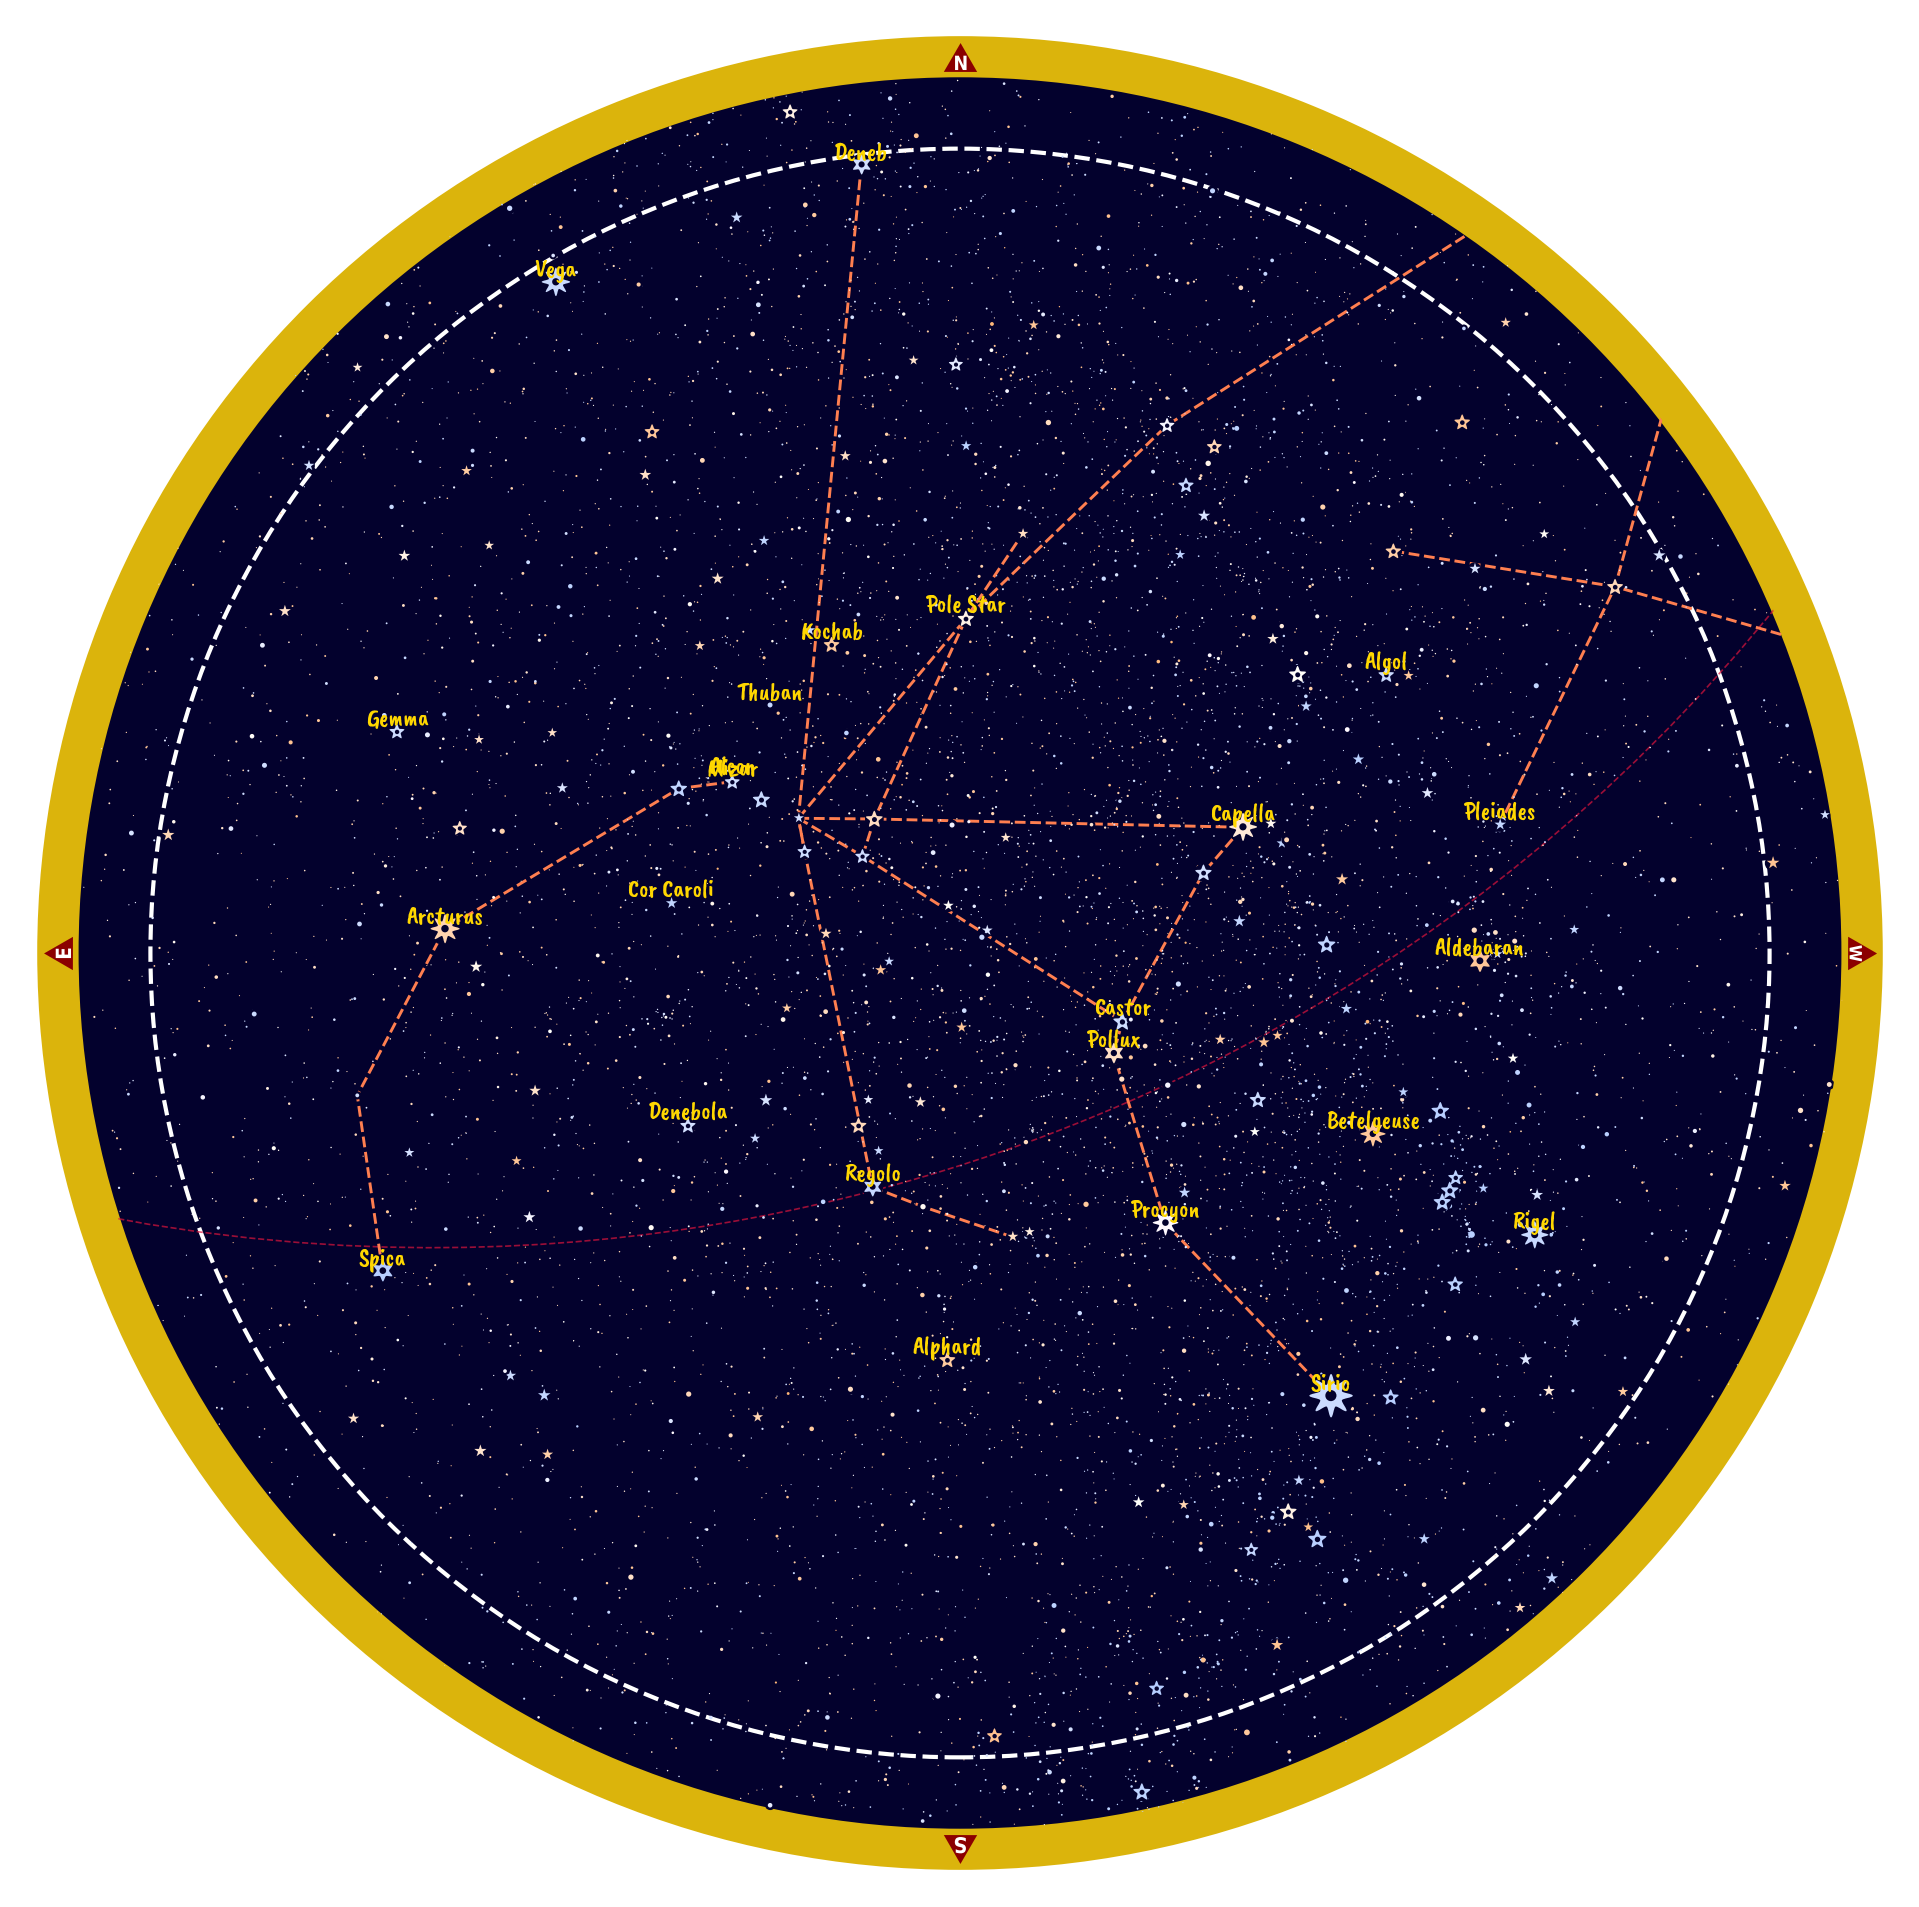

In [17]:
datetime_str = '27-3-2025 21:30'

date = datetime.strptime(datetime_str, '%d-%m-%Y %H:%M')
# Observer takes as input the latitude and longitude in decimal format (not sessagesimal)
observer = Observer('45 N','11 E')
observer.at_time(date, pytz.timezone('Europe/Rome'))
harey.plot_sky_view(observer, CON_LINES=False, HELPERS=True, STAR_NAMES=True, STAR_COLORS=True)


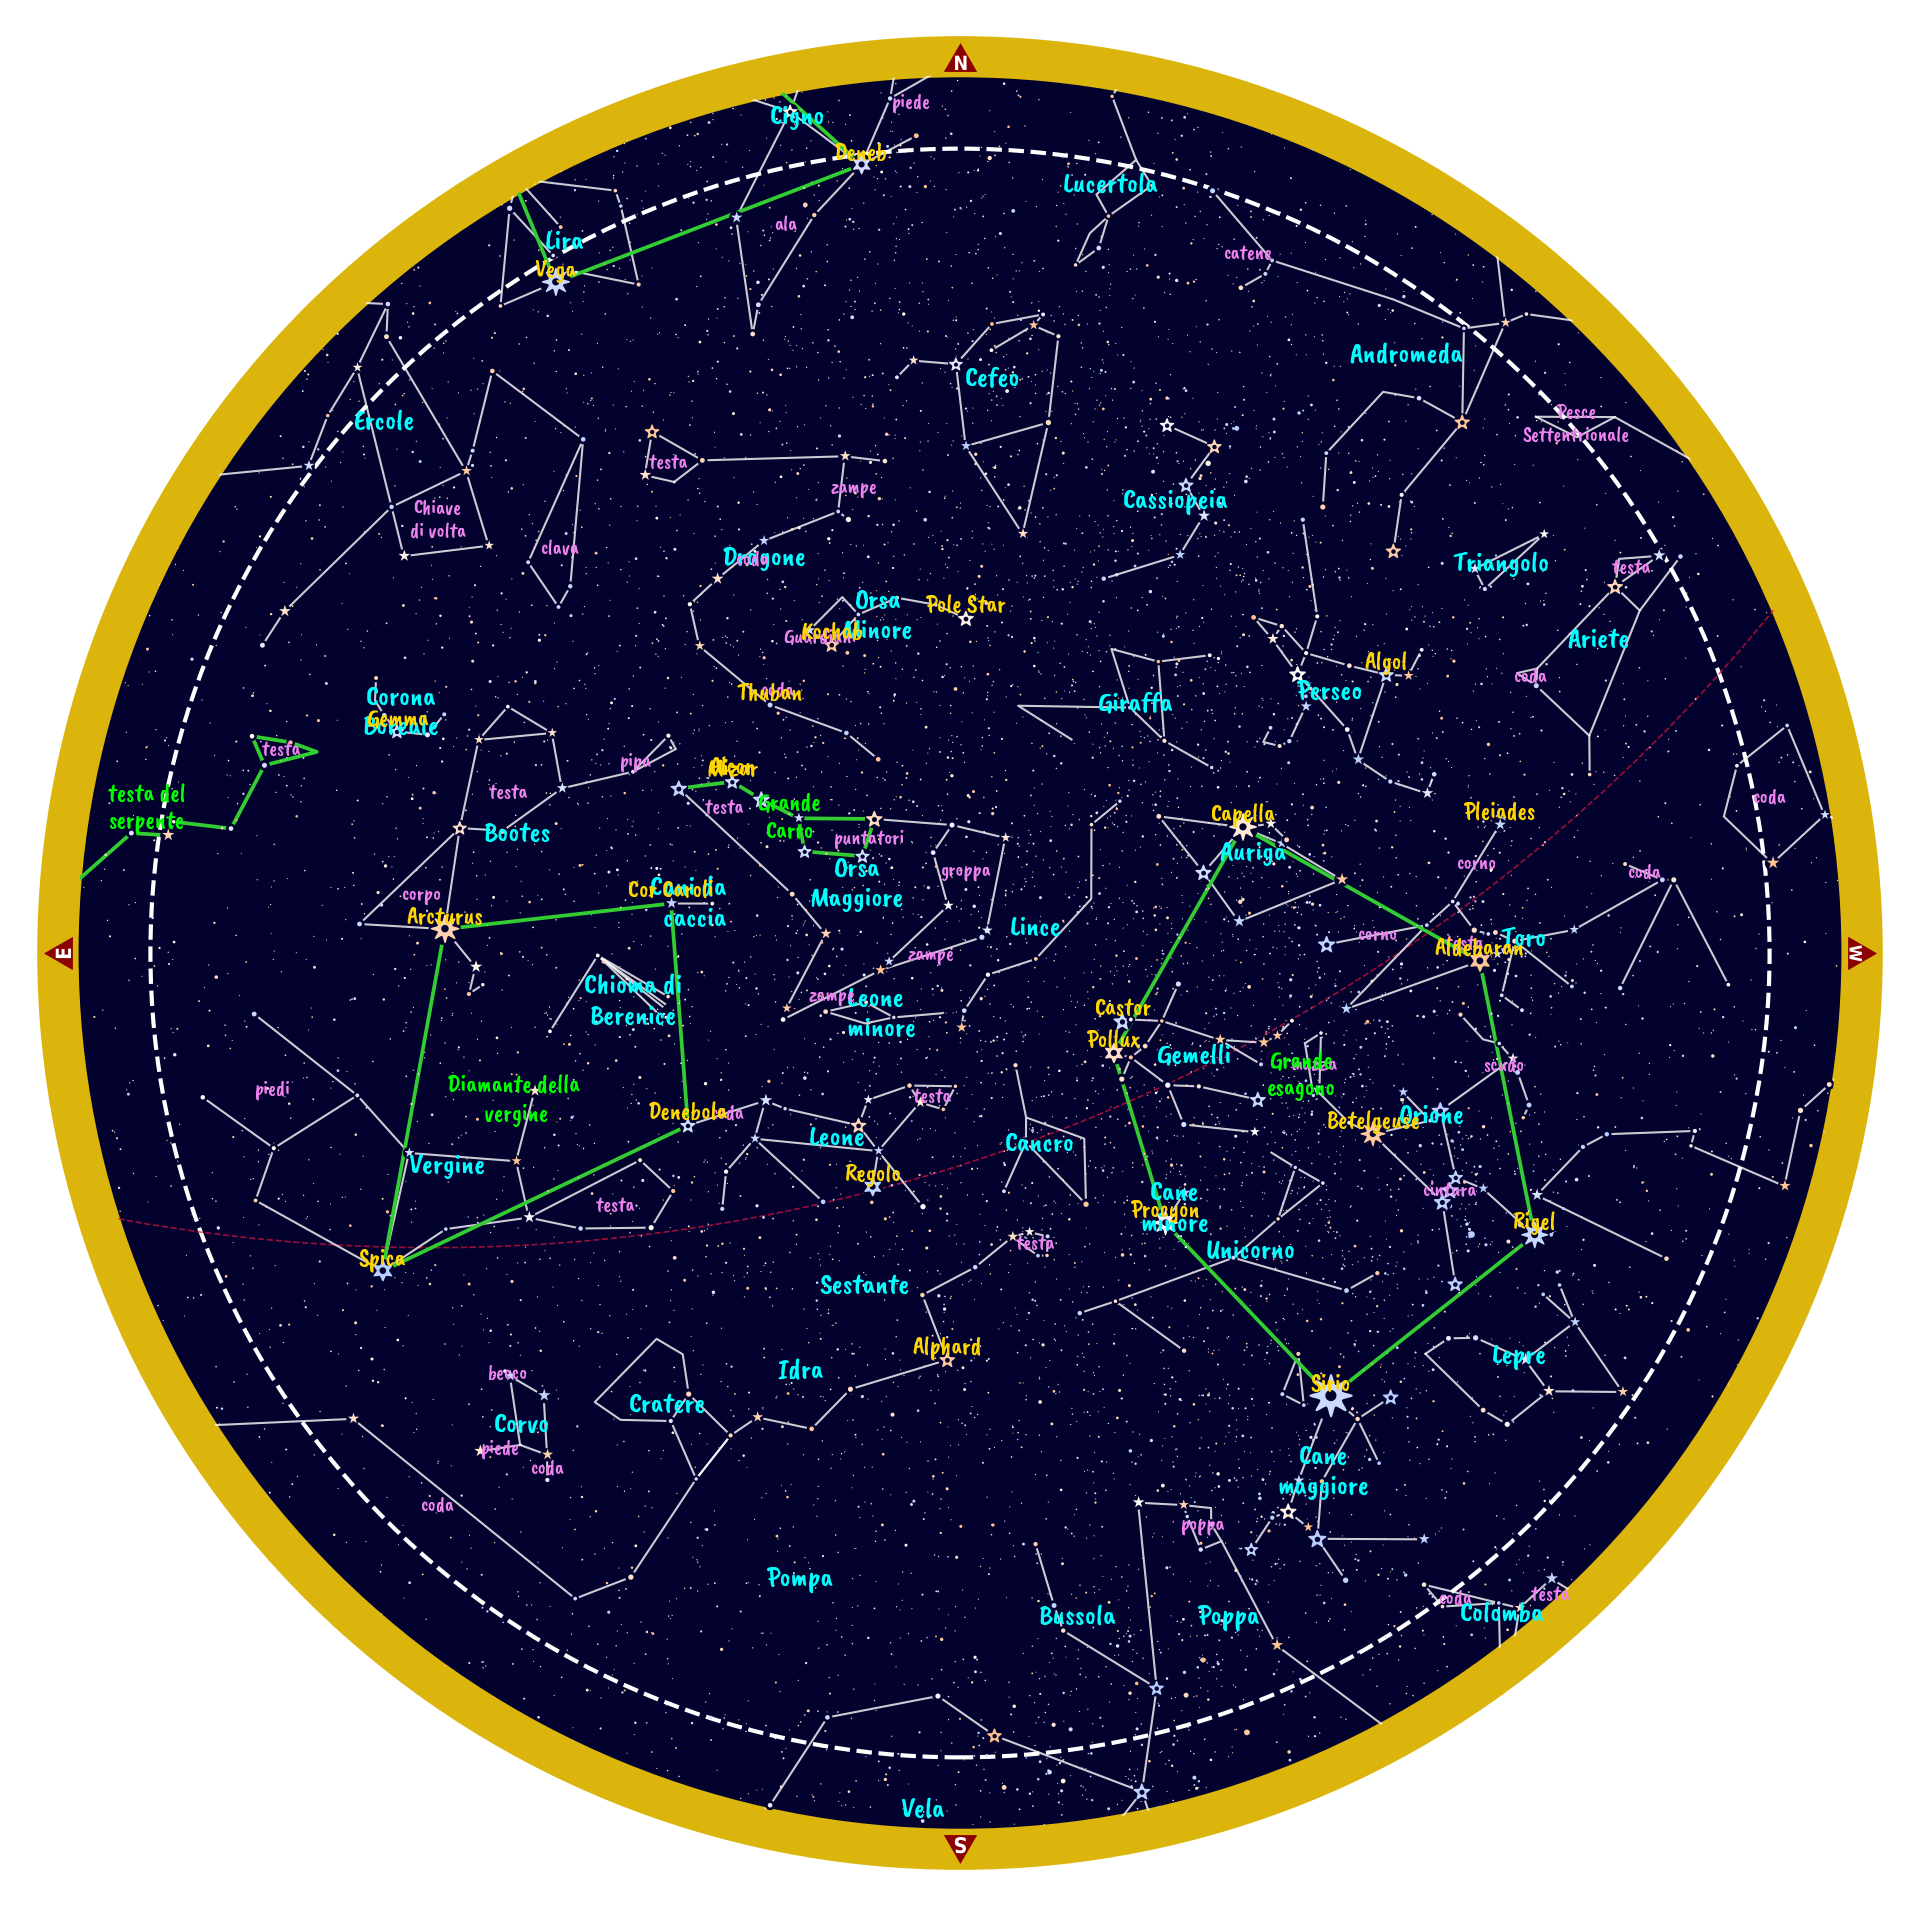

In [18]:
harey.plot_sky_view(observer, CON_LINES=True, CON_NAMES=True, STAR_NAMES=True, CON_PARTS=True, HELPERS=False, ASTERISMS=True, font_sizes=(5,6,7), SIS_SCRIPT=True, STAR_COLORS=True)

## Universal map of the sky
The universal map of the sky is divided in an equatorial map and two polar maps to reduce the deformations caused by projecting. The equatorial map uses the Gall stereographic projection, which compromises bewtween deformations of areas and angles minimize both. The polar projections instead use a stereographic projection, which preserves angles but deforms areas moving away from the center.

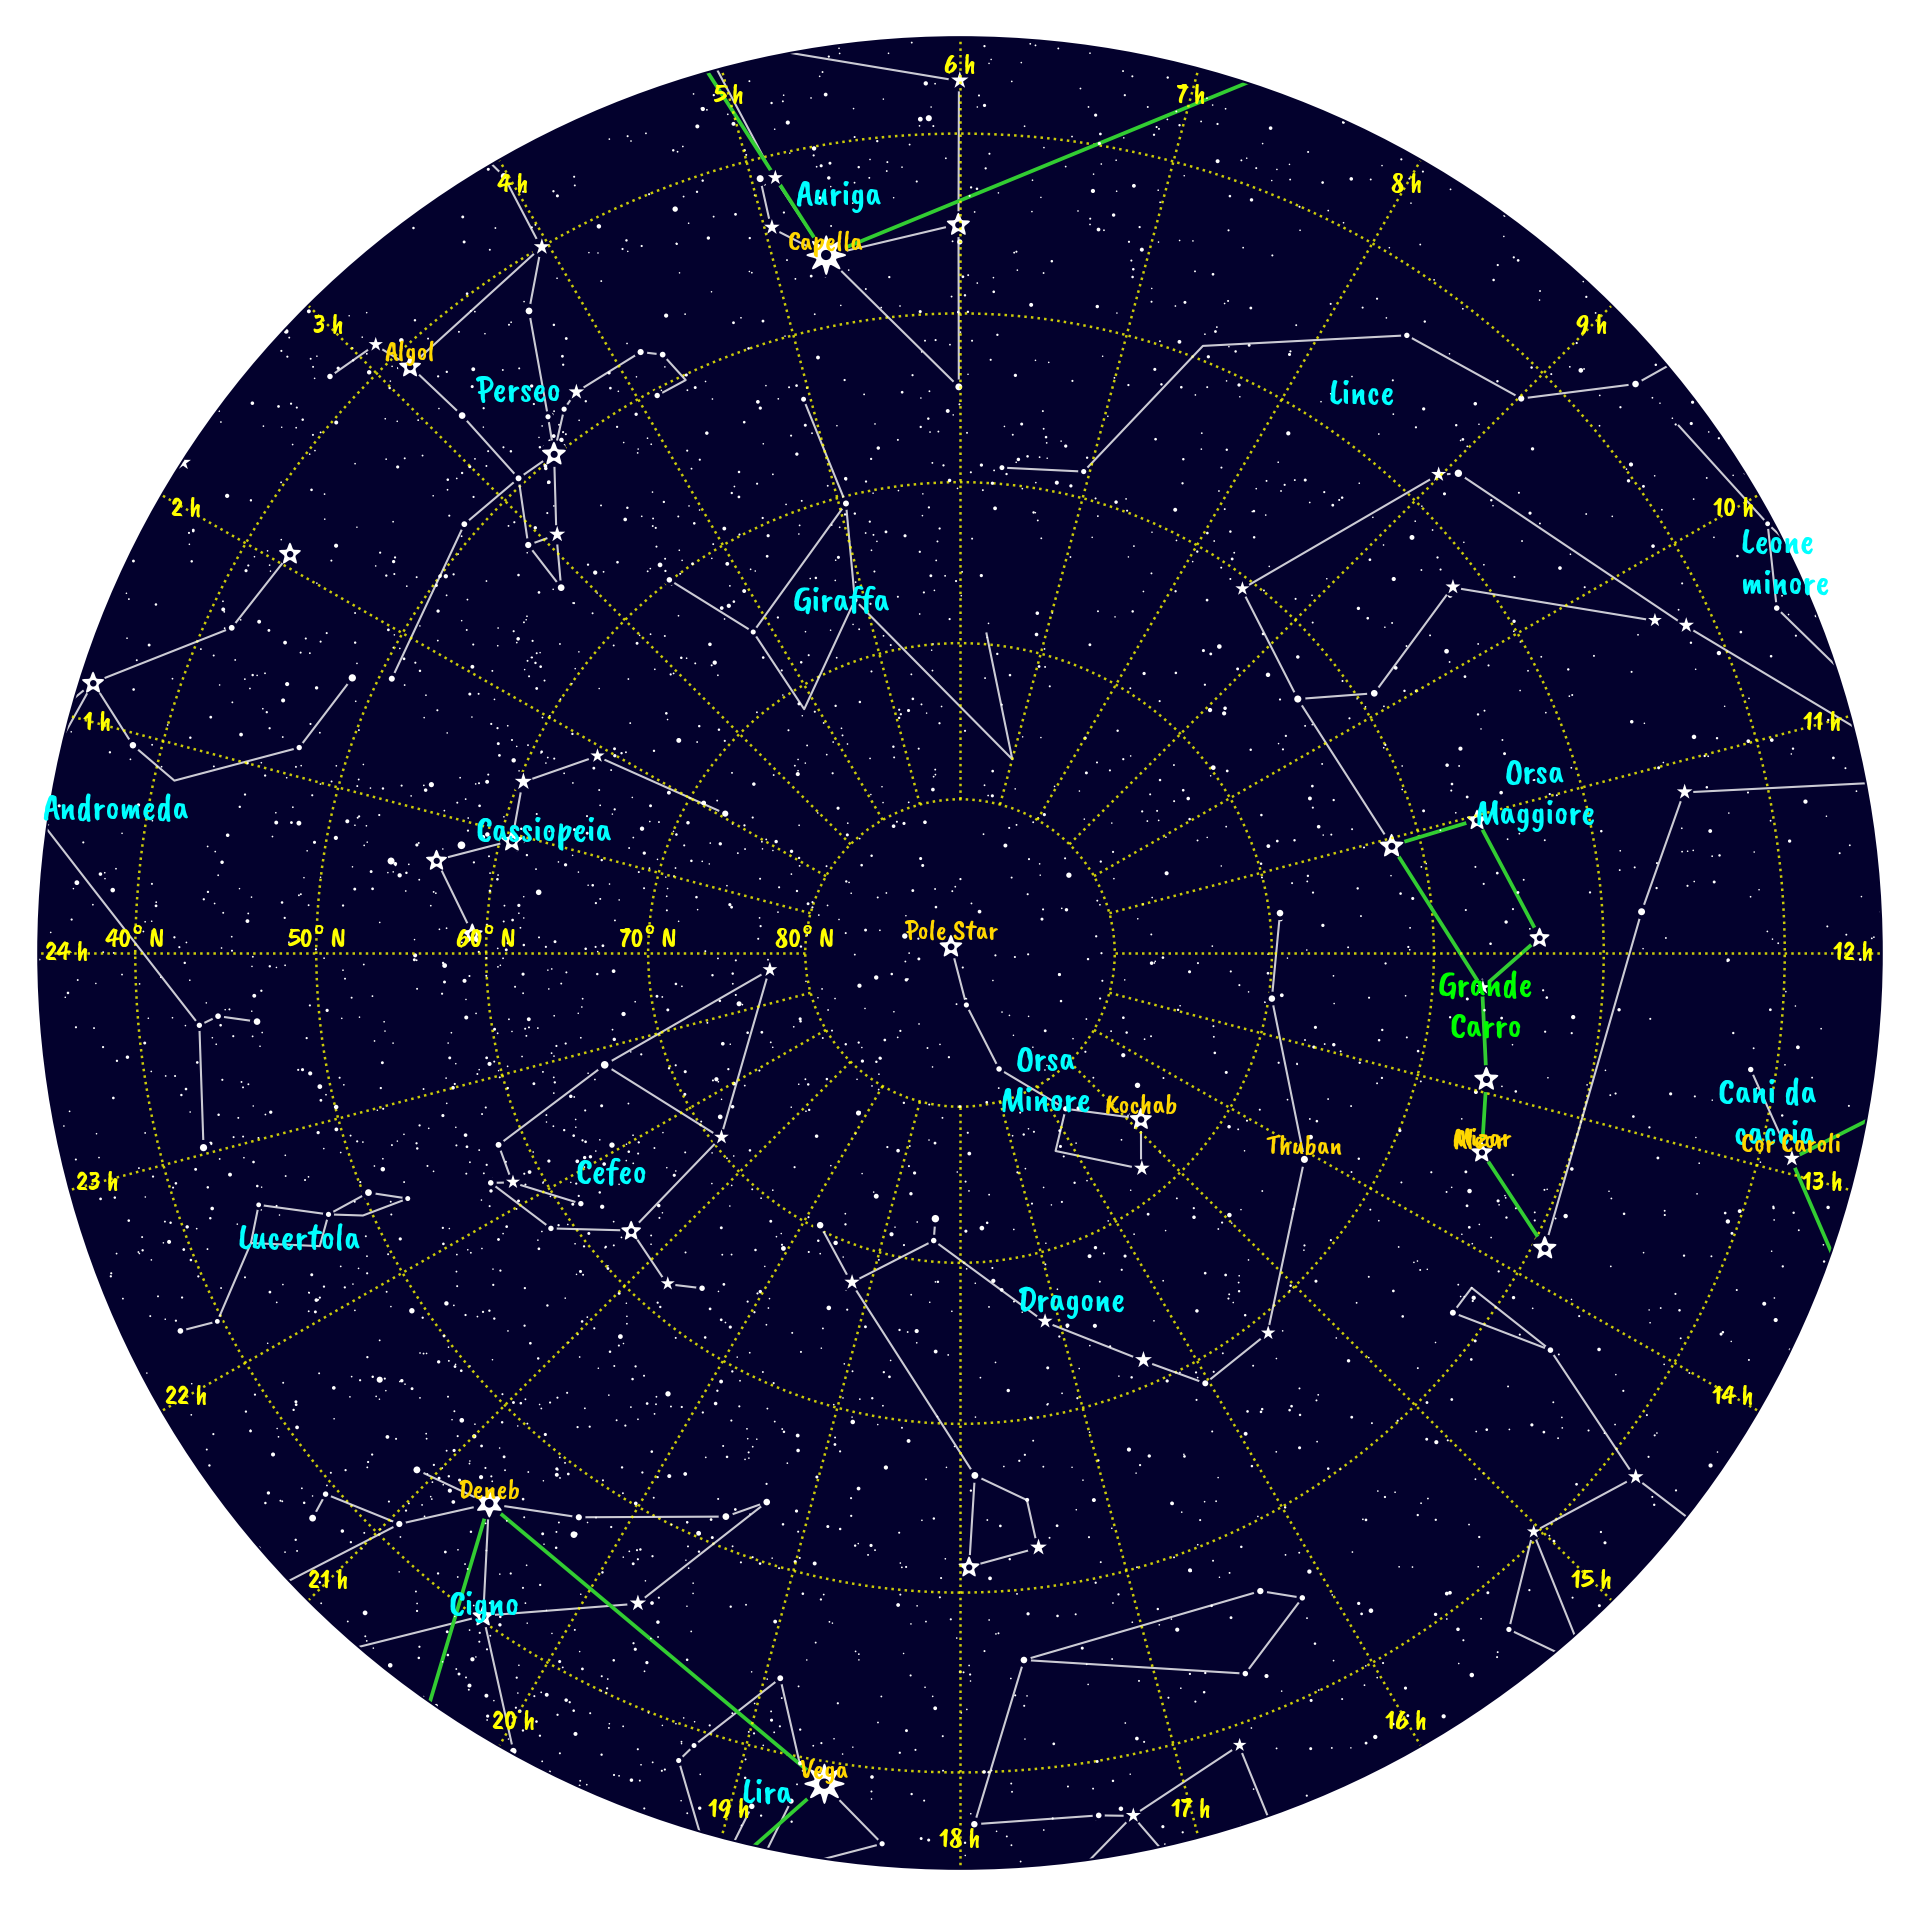

In [19]:
harey.polar_map(pole = 'N', FOV= 110, CON_LINES=True, GRID=True, CON_NAMES = True, ASTERISMS= True, STAR_NAMES = True, font_sizes=(7,8,9), SIS_SCRIPT=True)

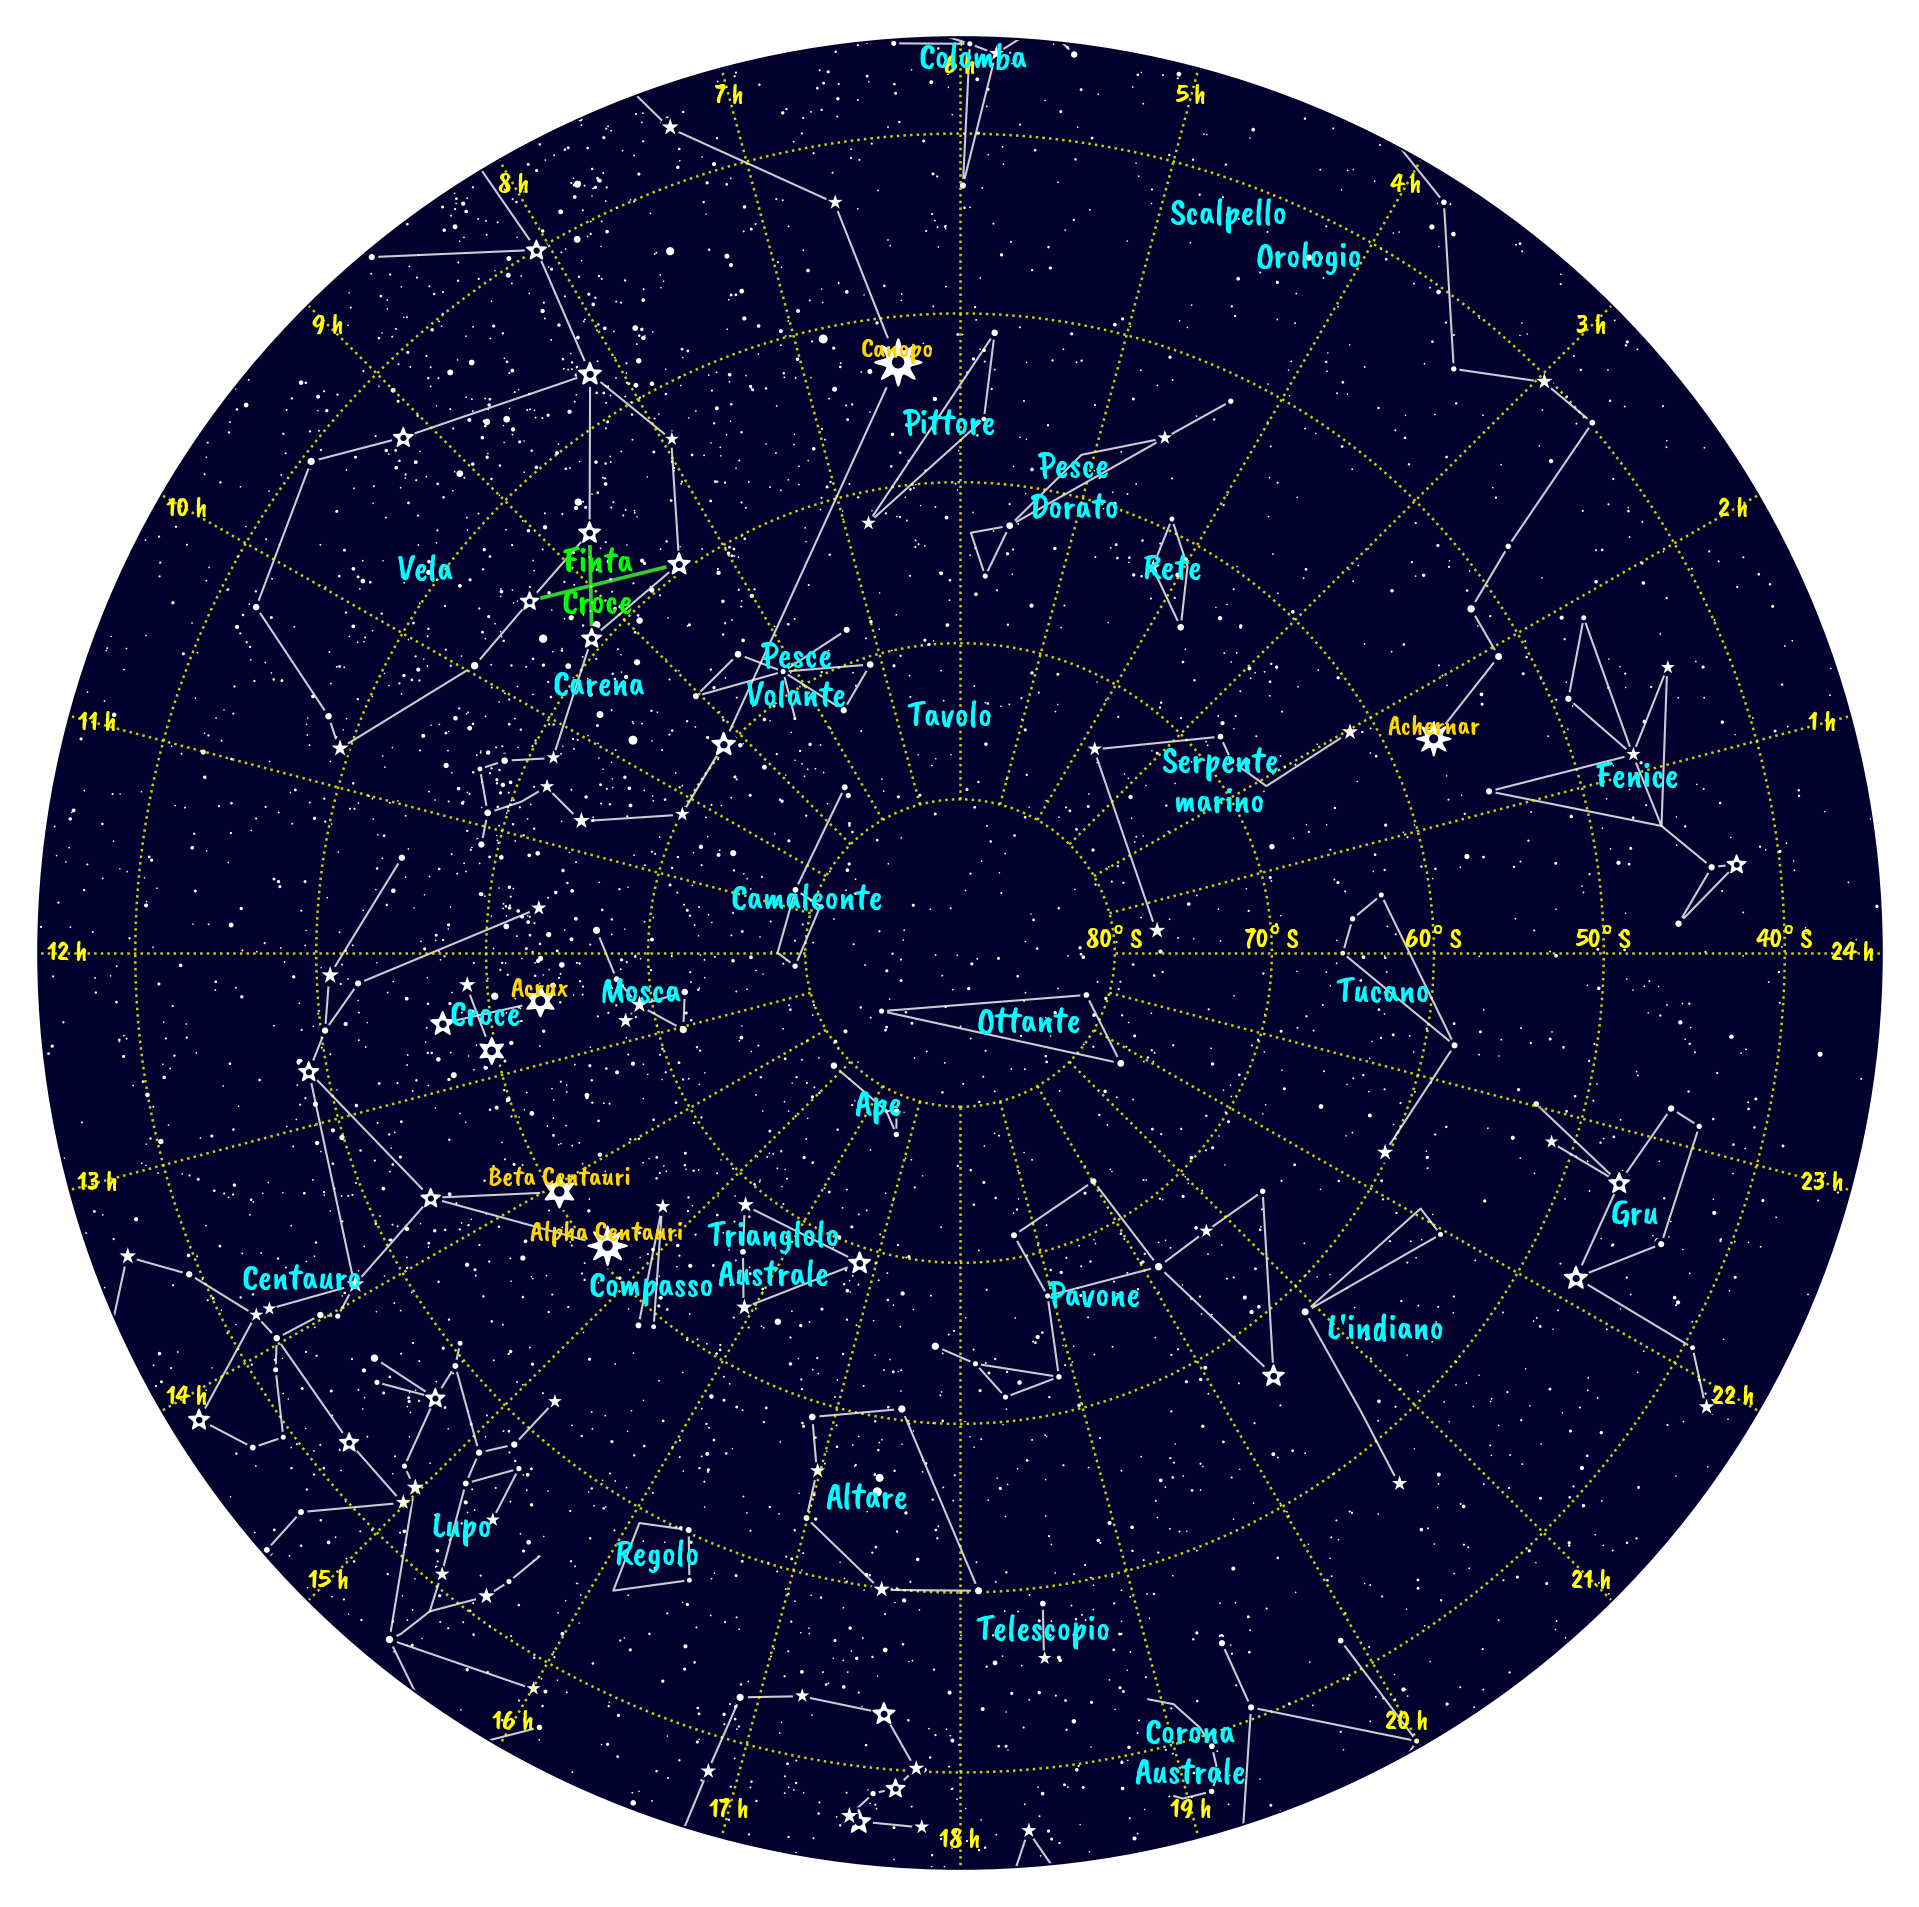

In [20]:
harey.polar_map(pole = 'S', FOV= 110, CON_LINES=True, GRID=True, CON_NAMES = True, ASTERISMS= True, STAR_NAMES = True, font_sizes=(7,8,9))

In the equatorial map I had to solve the problem of mapping a cylindrical surface to a plane, which caused the constellation near the edge to cross all the plot, messing up the whole map. For this reason, the map is composed by two sections stitched together. This solves the problem for constellation lines, but labels may appear outside of the plot borders.

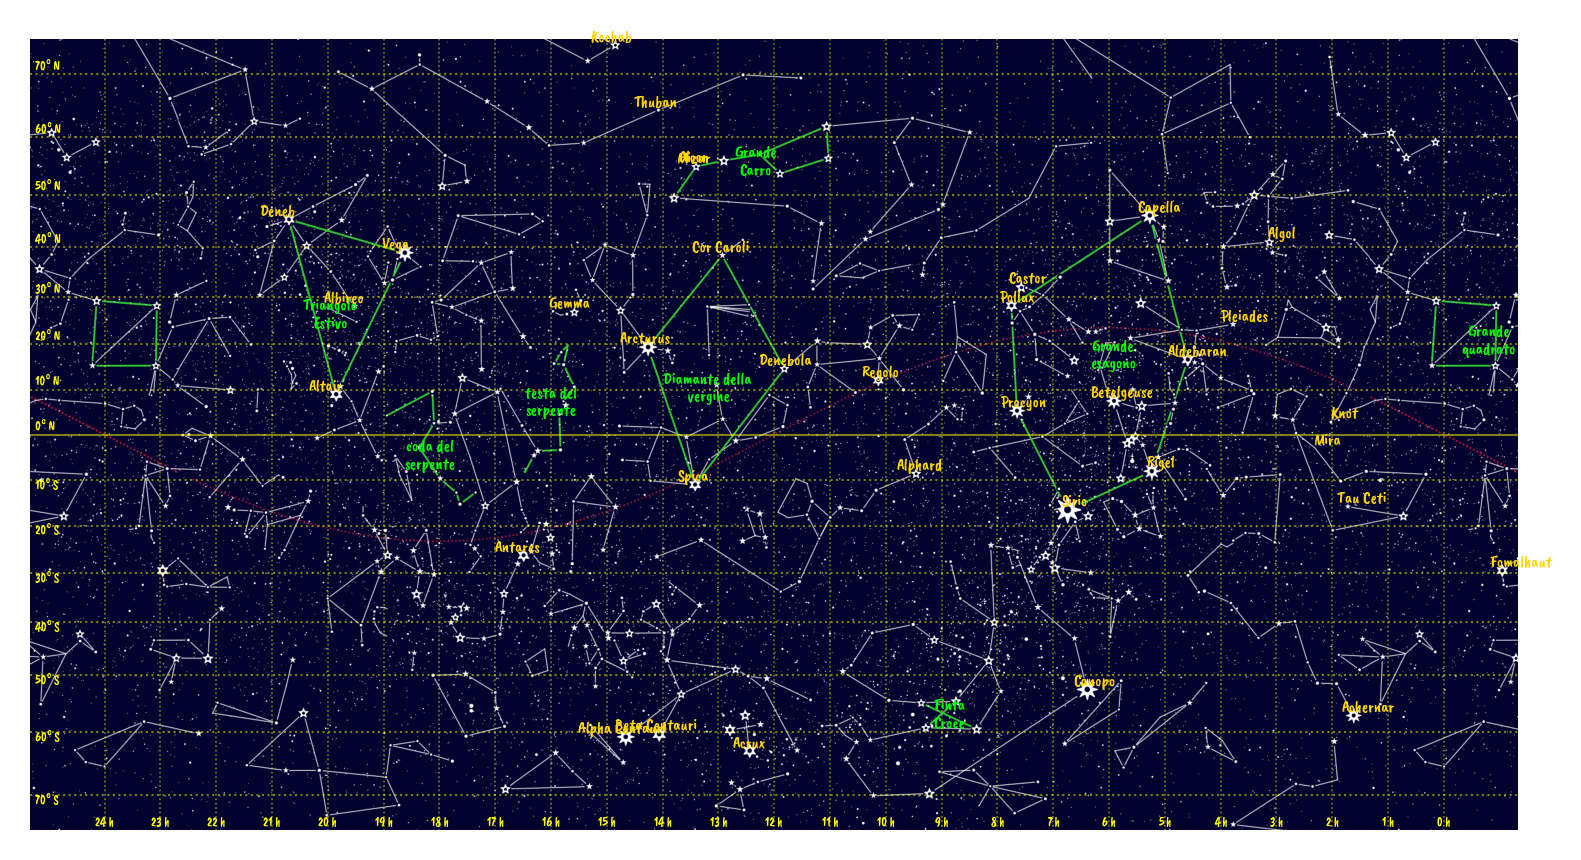

In [21]:
harey.equatorial_map(max_dims=(10,8), CON_LINES=True, GRID= True, STAR_NAMES=True, ASTERISMS=True, font_sizes=(3,4,5), star_size=80)

# Which constellations to print?

Not all constellations are the same, both in size and ease of recognition. Like HARey, I decided to focus on the ones that are bright and visible from where I live. Here I made a comparison between all the constellations, ordering them by visibility. __is_visible()__ classify a constellation by where it can be seen. Constellations are divided in visible, not visible, circumpolar (always visible) and partly visible (it assumes a perfect 180° FOV, which is nearly never the case).


In [ ]:
lat = '45 N'

constellations_df = []

# Take all the main constellations
for id in harey.constellation_ids:
    stars = harey.constellations[id]['stars']
    brightest_star = np.min(harey.stars.loc[stars, 'magnitude'])
    northmost_star = np.max(harey.stars.loc[stars, 'dec'])
    southmost_star = np.min(harey.stars.loc[stars, 'dec'])
    visibility =  is_visible(lat, (northmost_star, southmost_star))

    # Append the dictionary to the list
    constellations_df.append({'constellation': harey.names[id].replace('\n',' '), 'ID': id, 'brightest star':brightest_star,
                  'n_stars': len(harey.constellations[id]['stars']), 'visibility':visibility})

# Convert to pandas dataframe
constellations_df = pd.DataFrame(constellations_df)

# Filter out constellations which are not visible
constellations_df = constellations_df[(constellations_df['visibility'].str.contains('not visible') == False) & constellations_df['n_stars']>1]
constellations_df.sort_values(by = ['brightest star', 'n_stars']).head(5)

Empty DataFrame
Columns: [constellation, ID, brightest star, n_stars, visibility]
Index: []